## Extreme Event Detection for Air Quality Data

In this notebook, we approach the problem of predicting dangerous events in air quality from land-based sensor data in urban centres. We employ continual learning techniques to reintroduce instances of extreme events to the model and mitigate forgetting.

### The Problem
A decrease in air quality presents a significant hazard to the sustainability of environmental conditions in the modern world. Its significance in shaping health outcomes and the quality of life in urban areas is projected to escalate over time. Many factors, encompassing anthropogenic emissions and natural phenomena, are recognised as primary influencers contributing to the escalation of air pollution levels. Human health is particularly threatened by high amounts of pollution caused by weather events or disasters. However, these extreme events are difficult to predict using machine learning techniques due to their rapid onset and rarity.

### The Data
Particulate matter (PM) refers to the concentration of airborne particles of a certain diameter. We are particularly interested in PM2.5, which is the concentration of particulate matter less than 2.5 micrometers in diameter, because of its profound impact on human health. Recently, environmental scientists have established arrays of sensors in urban centres capable of approximating the number of particles of this size per cubic meter over a period of time. Our goal is to use sequences of these measurements to predict the concentration of particulate matter two hours from the present.

For this notebook, we use an air quality monitoring dataset from Vinnytsia, Ukraine: https://www.kaggle.com/datasets/vbmokin/air-quality-monitoring?select=data_saveecobot_14028.csv

In [1]:
import pandas as pd
import os
frames = []
directory = "vinnytsia"
for file in os.listdir(directory):
    filename = file
    if filename.endswith("1542.csv") and  filename.startswith("data"):
        name = os.path.join(directory, filename)
        df = pd.read_csv(name)
        df_new = df.pivot_table(index='datetime', columns='indicator_code', values='value', aggfunc="first").reset_index()
        drop_col = ["pressure_pa", "pressure", "heca_humidity", "heca_temperature"]
        for col in drop_col:
            if col in df_new:
                df_new = df_new.drop(columns=[col])
        df_new["pm25"] = df_new["pm25"]*10
        df_new["pm10"] = df_new["pm10"]*10
        df_new["sensor_id"] = name.split(".")[0].split("_")[-1]
        frames.append(df_new)
    else:
        continue
data = pd.concat(frames)
threshold = 0.5 * len(data)  # 50% threshold
data = data.dropna(axis=1, thresh=threshold)
data = data.dropna()
data = data[:10000]

display(data)

C:\Users\jacka\AppData\Local\Temp\ipykernel_117628\1197050171.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


indicator_code,datetime,humidity,pm10,pm25,temperature,sensor_id
0,2019-11-06 11:23:42,62.18,92.3,55.0,20.48,1542
1,2019-11-06 11:26:17,61.58,107.2,58.3,20.62,1542
2,2019-11-06 11:28:52,61.18,93.5,58.7,20.71,1542
3,2019-11-06 11:31:48,60.91,140.0,59.3,20.77,1542
4,2019-11-06 11:34:23,60.74,135.5,58.0,20.82,1542
...,...,...,...,...,...,...
10038,2020-02-13 09:38:35,75.51,215.3,91.3,2.30,1542
10039,2020-02-13 09:41:17,75.72,198.7,81.0,2.22,1542
10041,2020-02-13 09:46:37,75.81,253.7,127.7,2.24,1542
10042,2020-02-13 09:49:15,75.67,260.0,122.7,2.27,1542


Each row corresponds to a single reading at a timepoint for a single sensor. For example, row 0 contains a reading from sensor 1542 at 6:05am on the 25th of May 2023. We use the pm25 value to make our predictions, and drop columns missing more than 50% of values. For simplicity in this example, we make predictions over one sensor; however in practise an array of sensors may be used. For the Vinnytsia dataset, there is a significant distance between sensors, limiting the translation across sensors. We map the sensors in Vinnytsia as follows:

In [2]:
import folium

map_df = pd.read_csv("vinnytsia\Vinnytsia_region_about_stations_2021.csv")
# Data with latitude/longitude and values
map_obj = folium.Map(location = [49.3,28.9], zoom_start = 9, width="70%")
for source in set(map_df['id']):
    selected_data = map_df[map_df['id'] == source]
    radius = 12
    folium.CircleMarker(
        location=[list(selected_data['lat'])[0], list(selected_data['lng'])[0]],
        radius=radius,
        color="#3b638f",
        stroke=False,
        fill=True,
        fill_opacity=1,
        opacity=1,
        tooltip=source,
    ).add_to(map_obj)

map_obj

### Building a baseline model
Let's build a simple LSTM model to predict air quality. In this notebook we will simply build one model per approach for simplicity.

In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

data = data[pd.to_numeric(data['pm25'], errors='coerce').notnull()]
data = data[pd.to_numeric(data['pm10'], errors='coerce').notnull()]
selected_data = data
# Feature selection (replace with your features)
features = selected_data[['humidity','pm10','pm25','temperature','sensor_id']]

# Target variable (PM2.5 value from the sensor)
target = selected_data['pm25'].values.reshape(-1, 1)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
target_scaled = scaler.fit_transform(target)

# Create sequences for time series forecasting
sequence_length = 10  # Adjust this based on the characteristics of your time series data

X, y = [], []
for i in range(len(features_scaled) - sequence_length - 1):
    X.append(features_scaled[i:i + sequence_length, :])
    y.append(target_scaled[i + sequence_length + 1, 0])  # Use the value two hours in the future

X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

# Build an LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=1, batch_size=1)

# Evaluate the model on the testing set
test_loss = model.evaluate(X_test, y_test)
y_pred = model.predict(X_train)


(9989, 10, 5) (9989,)



281/281 [==============================] - 1s 2ms/step


We then plot the predicted values against the actual values:

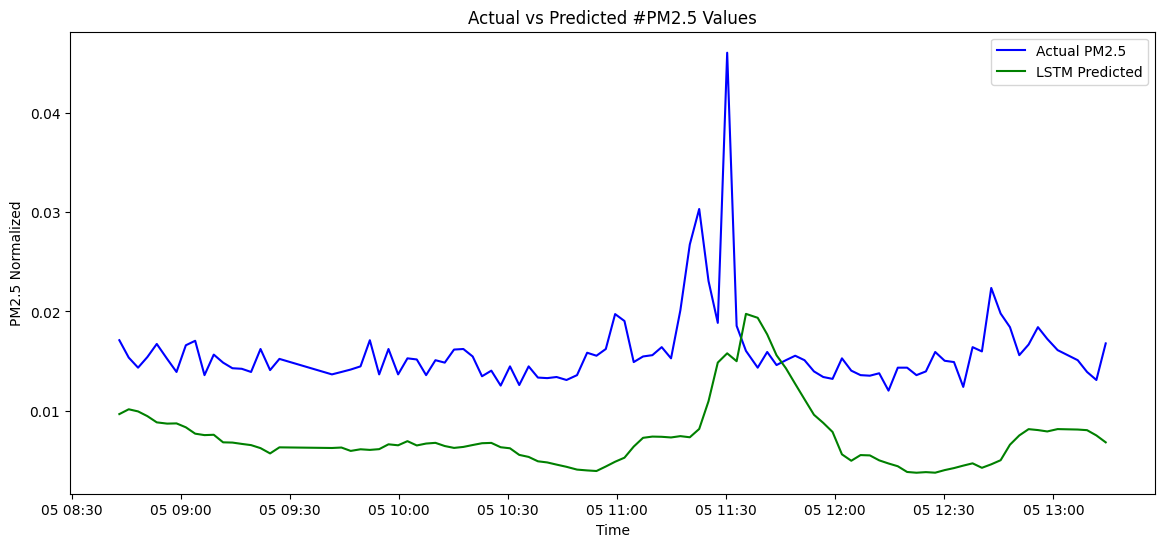

In [4]:
from dateutil import parser
dates = []
for i in selected_data['datetime'][500:600]:
    dates.append(parser.parse(i))

# Plot actual vs predicted values
plt.figure(figsize=(14, 6))
plt.plot(dates, y_train[500:600], label='Actual PM2.5', color='b')
plt.plot(dates, y_pred[500:600], label='LSTM Predicted', color='g')
plt.title('Actual vs Predicted #PM2.5 Values')
plt.xlabel('Time')
plt.ylabel('PM2.5 Normalized')
plt.legend()
plt.show()

Unfortunately, the model has trouble predicting the extreme event! We will start to implement the TSR method:

### Replay Buffer

We then introduce a replay buffer to store instances from previous air quality examples. We store these according to the Air Quality Index, organized into categories depending on health impacts on humans.

In [5]:
class ReplayBuffer:
    def __init__(self, max_task_size):
        self.tasks = [12.1, 35.5, 55.5, 150.5, 250.5]
        self.task_examples = {0 : [],
                              1 : [],
                              2 : [],
                              3 : [],
                              4 : [],
                              5 : []}
        self.max_task_size = max_task_size

    def identify_task(self, example):
        max_pm = max(example[0][2])
        for i in range(len(self.tasks)):
            if max_pm < self.tasks[i]:
                return i
            if max_pm > 250.5:
                return 5

    def add_example(self, example):
        task_index = self.identify_task(example)
        self.task_examples[task_index].append(example)
        if len(self.task_examples[task_index]) > self.max_task_size:
            self.task_examples[task_index].pop(0)

    def get_task_examples(self, task):
        if task in self.task_examples.keys():
            return self.task_examples[task]
        else:
            return None

### Applying Replay to Air Quality Prediction

Now, we apply replay to our baseline model to improve its performance. By assigning tasks to air quality events, our model, Time-Sensitive Replay (TSR) tracks a sequence of logits output on the prediction for each task encountered by the model. When drift is detected in this sequence, we assume that performance is about to decrease over that task, and so reintroduce data from that task. In this way, we improve the performance on extreme events, since the model is rehearsing on extreme event data when performance begins to decrease over those events.

In [8]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import random
from skmultiflow.drift_detection import KSWIN

data = data[pd.to_numeric(data['pm25'], errors='coerce').notnull()]
data = data[pd.to_numeric(data['pm10'], errors='coerce').notnull()]
selected_data = data
# Feature selection (replace with your features)
features = selected_data[['humidity','pm10','pm25','temperature']]

# Target variable (PM2.5 value from the sensor)
target = selected_data['pm25'].values.reshape(-1, 1)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
target_scaled = scaler.fit_transform(target)

# Create sequences for time series forecasting
sequence_length = 10  # Adjust this based on the characteristics of your time series data

X, y = [], []
for i in range(len(features_scaled) - sequence_length - 1):
    X.append(features_scaled[i:i + sequence_length, :])
    y.append(target_scaled[i + sequence_length + 1, 0])  # Use the value two hours in the future

X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

# Build an LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Replay buffer with buffer size 100
buffer = ReplayBuffer(100)

# Determine whether a task is undergoing forgetting
def validate_task(model, task):
    examples = buffer.get_task_examples(task)
    if examples == None or len(examples) == 0:
        return False
    kswin = KSWIN(alpha=0.01)
    for example in examples:
        x_v = example[0]
        y_v = example[1]
        kswin.add_element(model.evaluate(x_v, y_v, batch_size=1))
        if kswin.detected_change():
            print("y")
            return True

task_val = 0
replay_flag = False
example_num = 0
for example, label in zip(X_train, y_train):
    print(f"{example_num}/{len(X_train)}")
    example_num += 1
    # Validate previous tasks and test for drift
    if random.random() > 0.9:
        replay_flag = validate_task(model, task_val)
        buffer.add_example([example, label])
    else:
        replay_flag = False
    # Train the model on one example at a time
    example = np.reshape(example, (1, example.shape[0], example.shape[1]))
    label = np.reshape(label, (1, 1))
    model.fit(example, label, epochs=1, batch_size=1)
    # If drift detected over previous task validation, then replay.
    if replay_flag:
        replay = buffer.get_task_examples(task_val)
        for example in replay:
            example_replay = np.reshape(example[0], (1, example[0].shape[0], example[0].shape[1]))
            label_replay = np.reshape(example[1], (1, 1))
            model.fit(example_replay, label_replay, epochs=1, batch_size=1)
    task_val+=1
    task_val=task_val%6
    

# Evaluate the model on the testing set
test_loss = model.evaluate(X_test, y_test)
y_pred = model.predict(X_train)

(9989, 10, 4) (9989,)
0/8990
1/1 [==============================] - 0s 7ms/step - loss: 0.0043
1/8990
1/1 [==============================] - 0s 7ms/step - loss: 4.2705e-04
2/8990
1/1 [==============================] - 0s 7ms/step - loss: 7.2960e-04
3/8990
1/1 [==============================] - 0s 8ms/step - loss: 0.0021
4/8990
1/1 [==============================] - 0s 7ms/step - loss: 0.0014
5/8990
1/1 [==============================] - 0s 7ms/step - loss: 1.8421e-04
6/8990
1/1 [==============================] - 0s 7ms/step - loss: 7.2540e-05
7/8990
1/1 [==============================] - 0s 7ms/step - loss: 6.9538e-04
8/8990
1/1 [==============================] - 0s 7ms/step - loss: 0.0011
9/8990
1/1 [==============================] - 0s 7ms/step - loss: 0.0012
10/8990
1/1 [==============================] - 0s 8ms/step - loss: 5.1258e-04
11/8990
1/1 [==============================] - 0s 7ms/step - loss: 1.0086e-07
12/8990
1/1 [==============================] - 0s 7ms/step - loss: 1.861

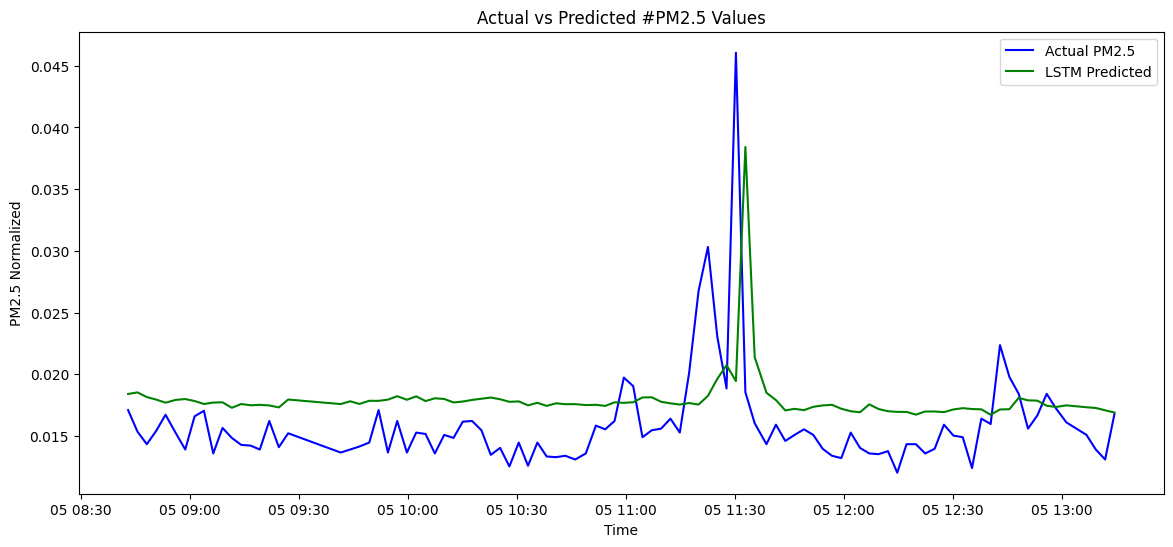

In [15]:
from dateutil import parser
dates = []
for i in selected_data['datetime'][500:600]:
    dates.append(parser.parse(i))
# Plot actual vs predicted values
plt.figure(figsize=(14, 6))
plt.plot(dates, y_train[500:600], label='Actual PM2.5', color='b')
plt.plot(dates, y_pred[500:600], label='LSTM Predicted', color='g')
plt.title('Actual vs Predicted #PM2.5 Values')
plt.xlabel('Time')
plt.ylabel('PM2.5 Normalized')
plt.legend()
plt.show()

### Next Steps

We observe that TSR provides some performance increase in terms of loss and extreme event detection, but in these tests we do not account for relevant environmental factors such as wind direction.

It would also be interesting to expand our definition of tasks to capture observed behaviours in urban centres instead of fixing tasks according to air quality intervals. Tasks derived from time periods may allow the model to avoid forgetting summer behaviours during winter months.

We hope this notebook was useful and interesting! Feel free to send any questions to jjul482@aucklanduni.ac.nz if you have any queries regarding this work.